In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
from pyspark.sql.types import StructType, ArrayType
from pyspark.sql import functions as F
from helper import read_sql_file, plot_multiple_line_graphs
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Big Data And Cloud Computing Laboratory Report

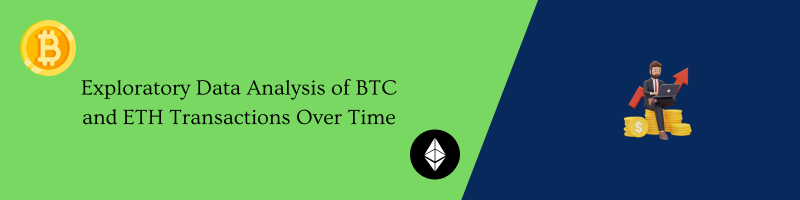

## EXECUTIVE SUMMARY

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## INTRODUCTION

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Create Spark Session 

In [2]:
spark = SparkSession.builder.appName("BDCCLab").master("local[*]").getOrCreate()

In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

## Show Raw Data Size 

In [4]:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/

901G	/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/


In [5]:
# Size of data being processed:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/

1.5T	/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/


## Read Raw Data

In [6]:
df_eth_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/")

In [7]:
df_btc_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/")

## ETH Transactions Schema

In [8]:
df_eth_trans.printSchema()

root
 |-- gas: long (nullable = true)
 |-- hash: string (nullable = true)
 |-- input: string (nullable = true)
 |-- nonce: long (nullable = true)
 |-- value: double (nullable = true)
 |-- block_number: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- transaction_index: long (nullable = true)
 |-- from_address: string (nullable = true)
 |-- to_address: string (nullable = true)
 |-- gas_price: long (nullable = true)
 |-- receipt_cumulative_gas_used: long (nullable = true)
 |-- receipt_gas_used: long (nullable = true)
 |-- receipt_contract_address: string (nullable = true)
 |-- receipt_status: long (nullable = true)
 |-- receipt_effective_gas_price: long (nullable = true)
 |-- transaction_type: long (nullable = true)
 |-- max_fee_per_gas: long (nullable = true)
 |-- max_priority_fee_per_gas: long (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- last_modified: timestamp (nullable = true)



## BTC Transactions Schema

In [9]:
df_btc_trans.printSchema()

root
 |-- hash: string (nullable = true)
 |-- version: long (nullable = true)
 |-- size: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- block_number: long (nullable = true)
 |-- virtual_size: long (nullable = true)
 |-- lock_time: long (nullable = true)
 |-- input_count: long (nullable = true)
 |-- output_count: long (nullable = true)
 |-- is_coinbase: boolean (nullable = true)
 |-- output_value: double (nullable = true)
 |-- outputs: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- required_signatures: long (nullable = true)
 |    |    |-- script_asm: string (nullable = true)
 |    |    |-- script_hex: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- value: double (nullable = true)
 |    |    |-- address: string (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- index: long (nullable = tru

In [10]:
# df_btc_trans.show(2, vertical=True)

## Register Temporary Views

In [11]:
df_eth_trans.createOrReplaceTempView("df_eth_trans")
df_btc_trans.createOrReplaceTempView("df_btc_trans")

## BTC and ETH Comparisons on Count and Total and Average Value and Fees

In [12]:
eth_tot_trans = spark.sql("""
WITH value AS (
	SELECT 
        year(date) AS year, 
        AVG(value/1E18) AS avg_value,
        AVG(CASE 
                WHEN receipt_status = 1 AND receipt_effective_gas_price > 0 
                THEN receipt_effective_gas_price/1E18 
                ELSE 0 
            END) AS avg_gas,
        SUM(value/1E18) AS total_value,
        SUM(CASE 
                WHEN receipt_status = 1 AND receipt_effective_gas_price > 0 
                THEN receipt_effective_gas_price/1E18 
                ELSE 0 
            END) AS total_gas,
        COUNT(*) AS count
	FROM df_eth_trans
	GROUP BY year(date)
	ORDER BY year
)
SELECT
	year,
	total_value,
    total_gas,
    avg_value,
    avg_gas,
    count AS total_transactions
FROM value;
 
""").toPandas()
eth_tot_trans

,year,total_value,total_gas,avg_value,avg_gas,total_transactions
0,2015,9.184474e+07,0.066232,87.781841,6.330245e-08,1046284
1,2016,6.625570e+08,0.409877,48.499609,3.000327e-08,13661080
2,2017,4.353256e+09,2.557807,42.288832,2.484730e-08,102941034
3,2018,1.142012e+09,5.449470,4.546831,2.169664e-08,251166529
4,2019,7.653053e+08,3.824180,3.151582,1.574825e-08,242832115
5,2020,9.428725e+08,23.000077,2.734811,6.671195e-08,344766970
6,2021,9.920981e+08,47.371433,2.148294,1.025783e-07,461807363
7,2022,6.946280e+08,19.230624,1.700256,4.707121e-08,408543268
8,2023,4.534225e+08,12.622046,1.183560,3.294708e-08,383100651
9,2024,1.851720e+08,4.934517,1.192735,3.178433e-08,155249958


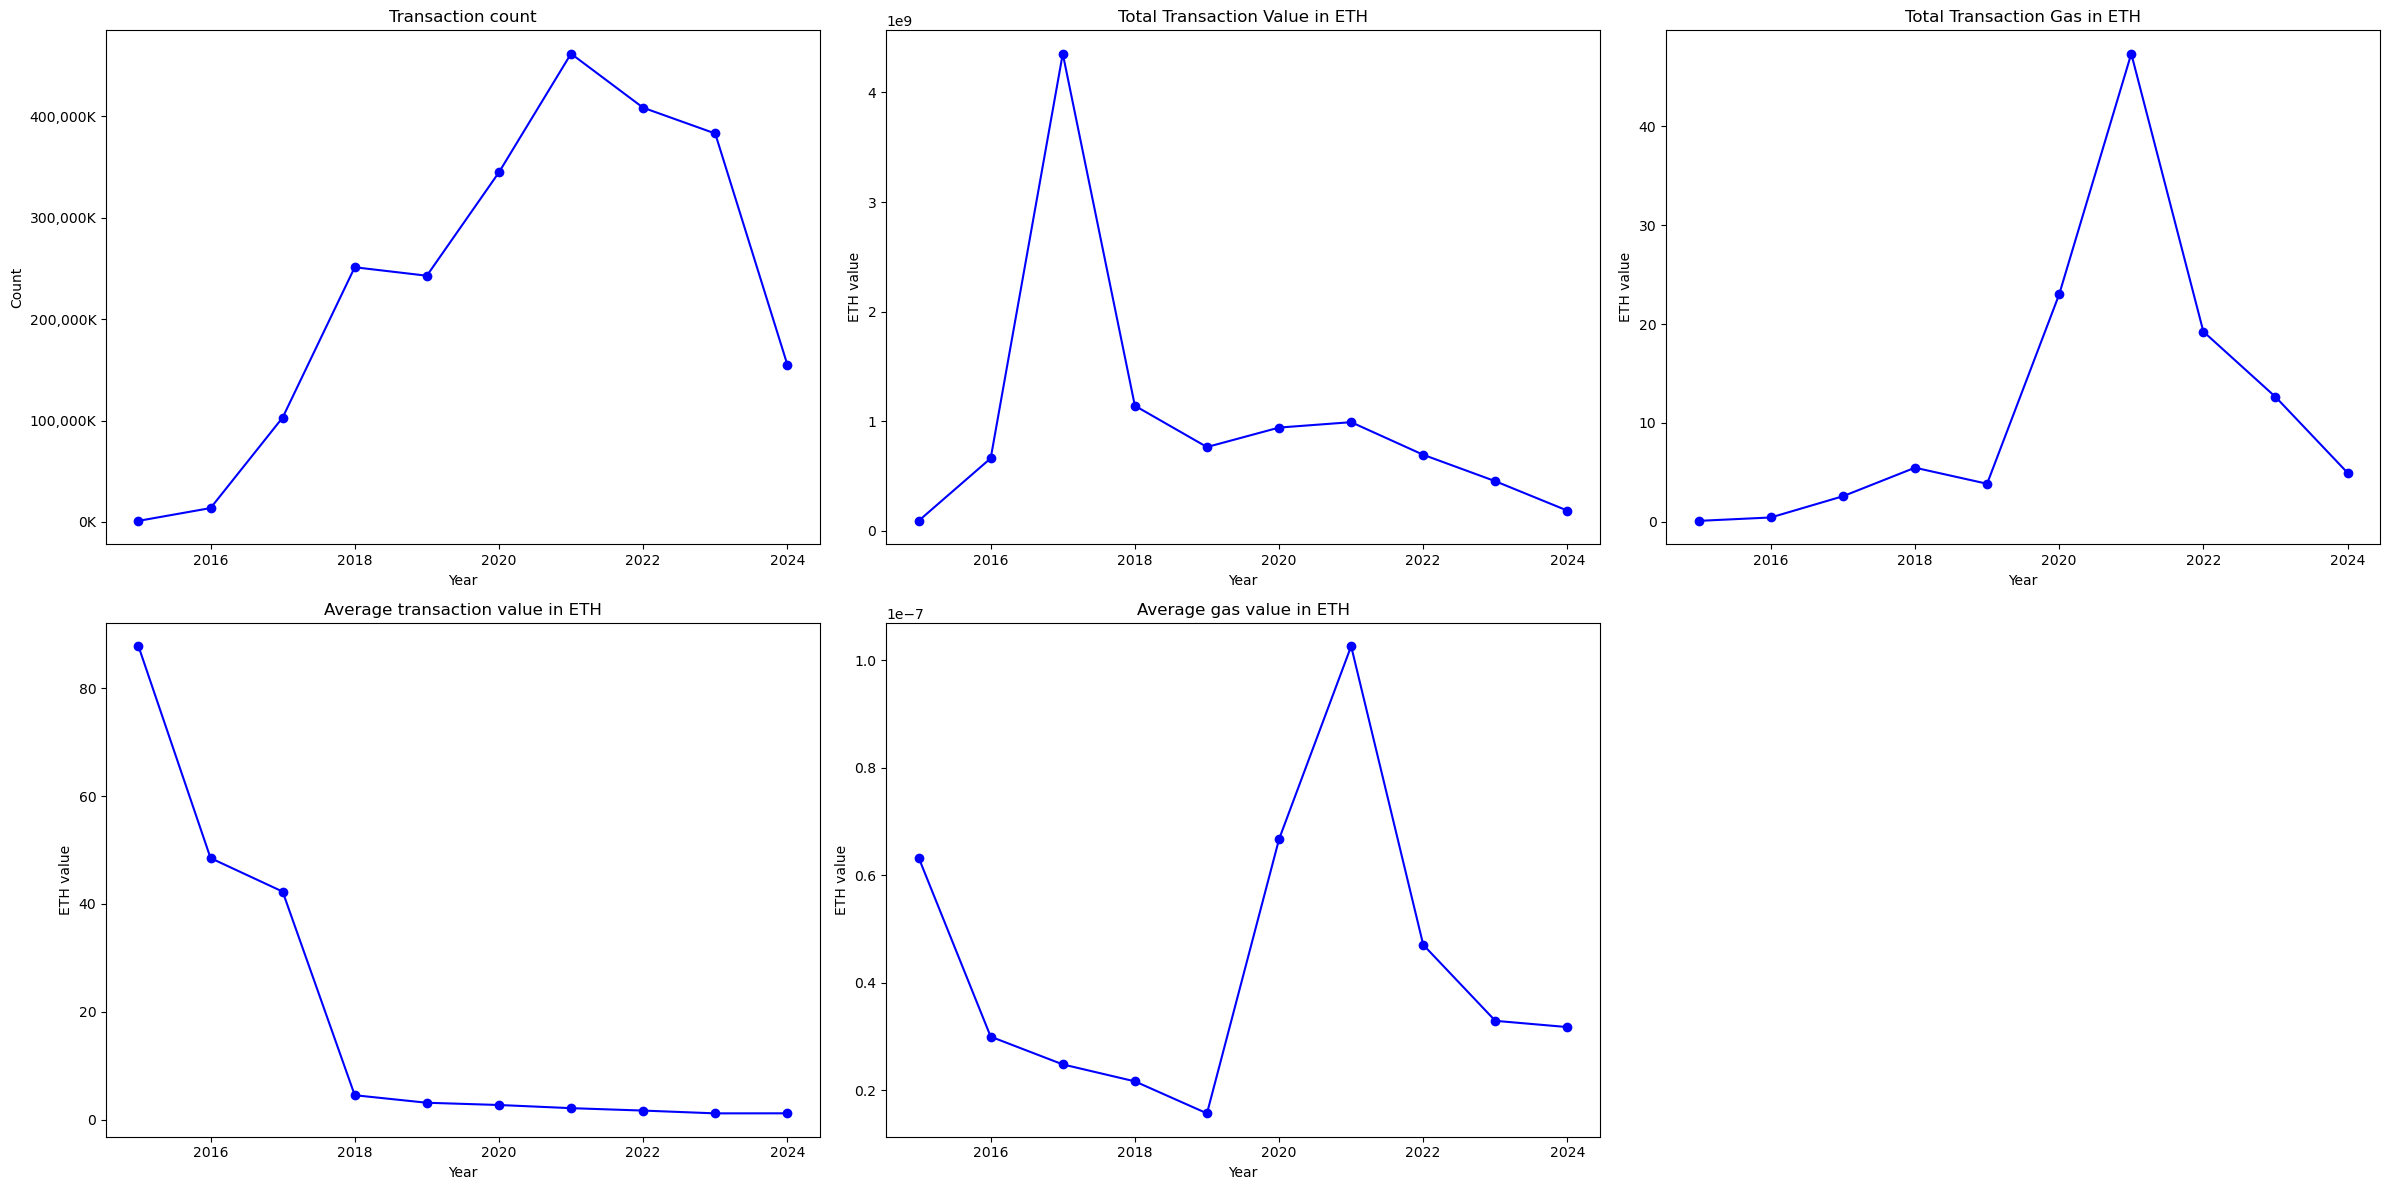

In [22]:
plot_multiple_line_graphs(
    x_list=[eth_tot_trans["year"]] * 5,
    y_list=[eth_tot_trans["total_transactions"], eth_tot_trans["total_value"], eth_tot_trans["total_gas"], eth_tot_trans["avg_value"], eth_tot_trans["avg_gas"]],
    x_labels=["Year"] * 5,
    y_labels=["Count", "ETH value",  "ETH value", "ETH value", "ETH value"],
    titles=["Transaction count", "Total Transaction Value in ETH", "Total Transaction Gas in ETH", "Average transaction value in ETH", "Average gas value in ETH"],
    use_k=[True, False, False, False, False],
    show_grid=False,
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [18]:
btc_tot_trans = spark.sql("""
WITH value AS (
	SELECT 
        year(date) AS year, 
        AVG(input_value) AS avg_value,
        AVG(fee) AS avg_fee,
        SUM(input_value) AS total_value,
        SUM(fee) AS total_fee,
        COUNT(*) AS count
	FROM df_btc_trans
	GROUP BY year(date)
	ORDER BY year
)
SELECT
	year,
	avg_value,
    avg_fee,
    total_value,
    total_fee,
    count AS total_transactions
FROM value;
""").toPandas()
btc_tot_trans

,year,avg_value,avg_fee,total_value,total_fee,total_transactions
0,2009,230.000000,0.000000,1.150000e+03,0.000000,32709
1,2010,134.682635,0.000229,1.271040e+07,21.591013,185305
2,2011,160.148884,0.001676,2.948767e+08,3086.340796,1901765
3,2012,109.886395,0.000811,9.168147e+08,6766.706688,8453050
4,2013,21.875829,0.000780,4.283245e+08,15274.635981,19643241
5,2014,10.422027,0.000184,2.626857e+08,4636.574089,25263720
6,2015,11.955067,0.000180,5.391198e+08,8109.502888,45674023
7,2016,12.927879,0.000273,1.067038e+09,22548.383140,82626623
8,2017,8.960290,0.000965,9.319356e+08,100370.686083,104063229
9,2018,5.174042,0.000315,4.196391e+08,25544.523016,81395636


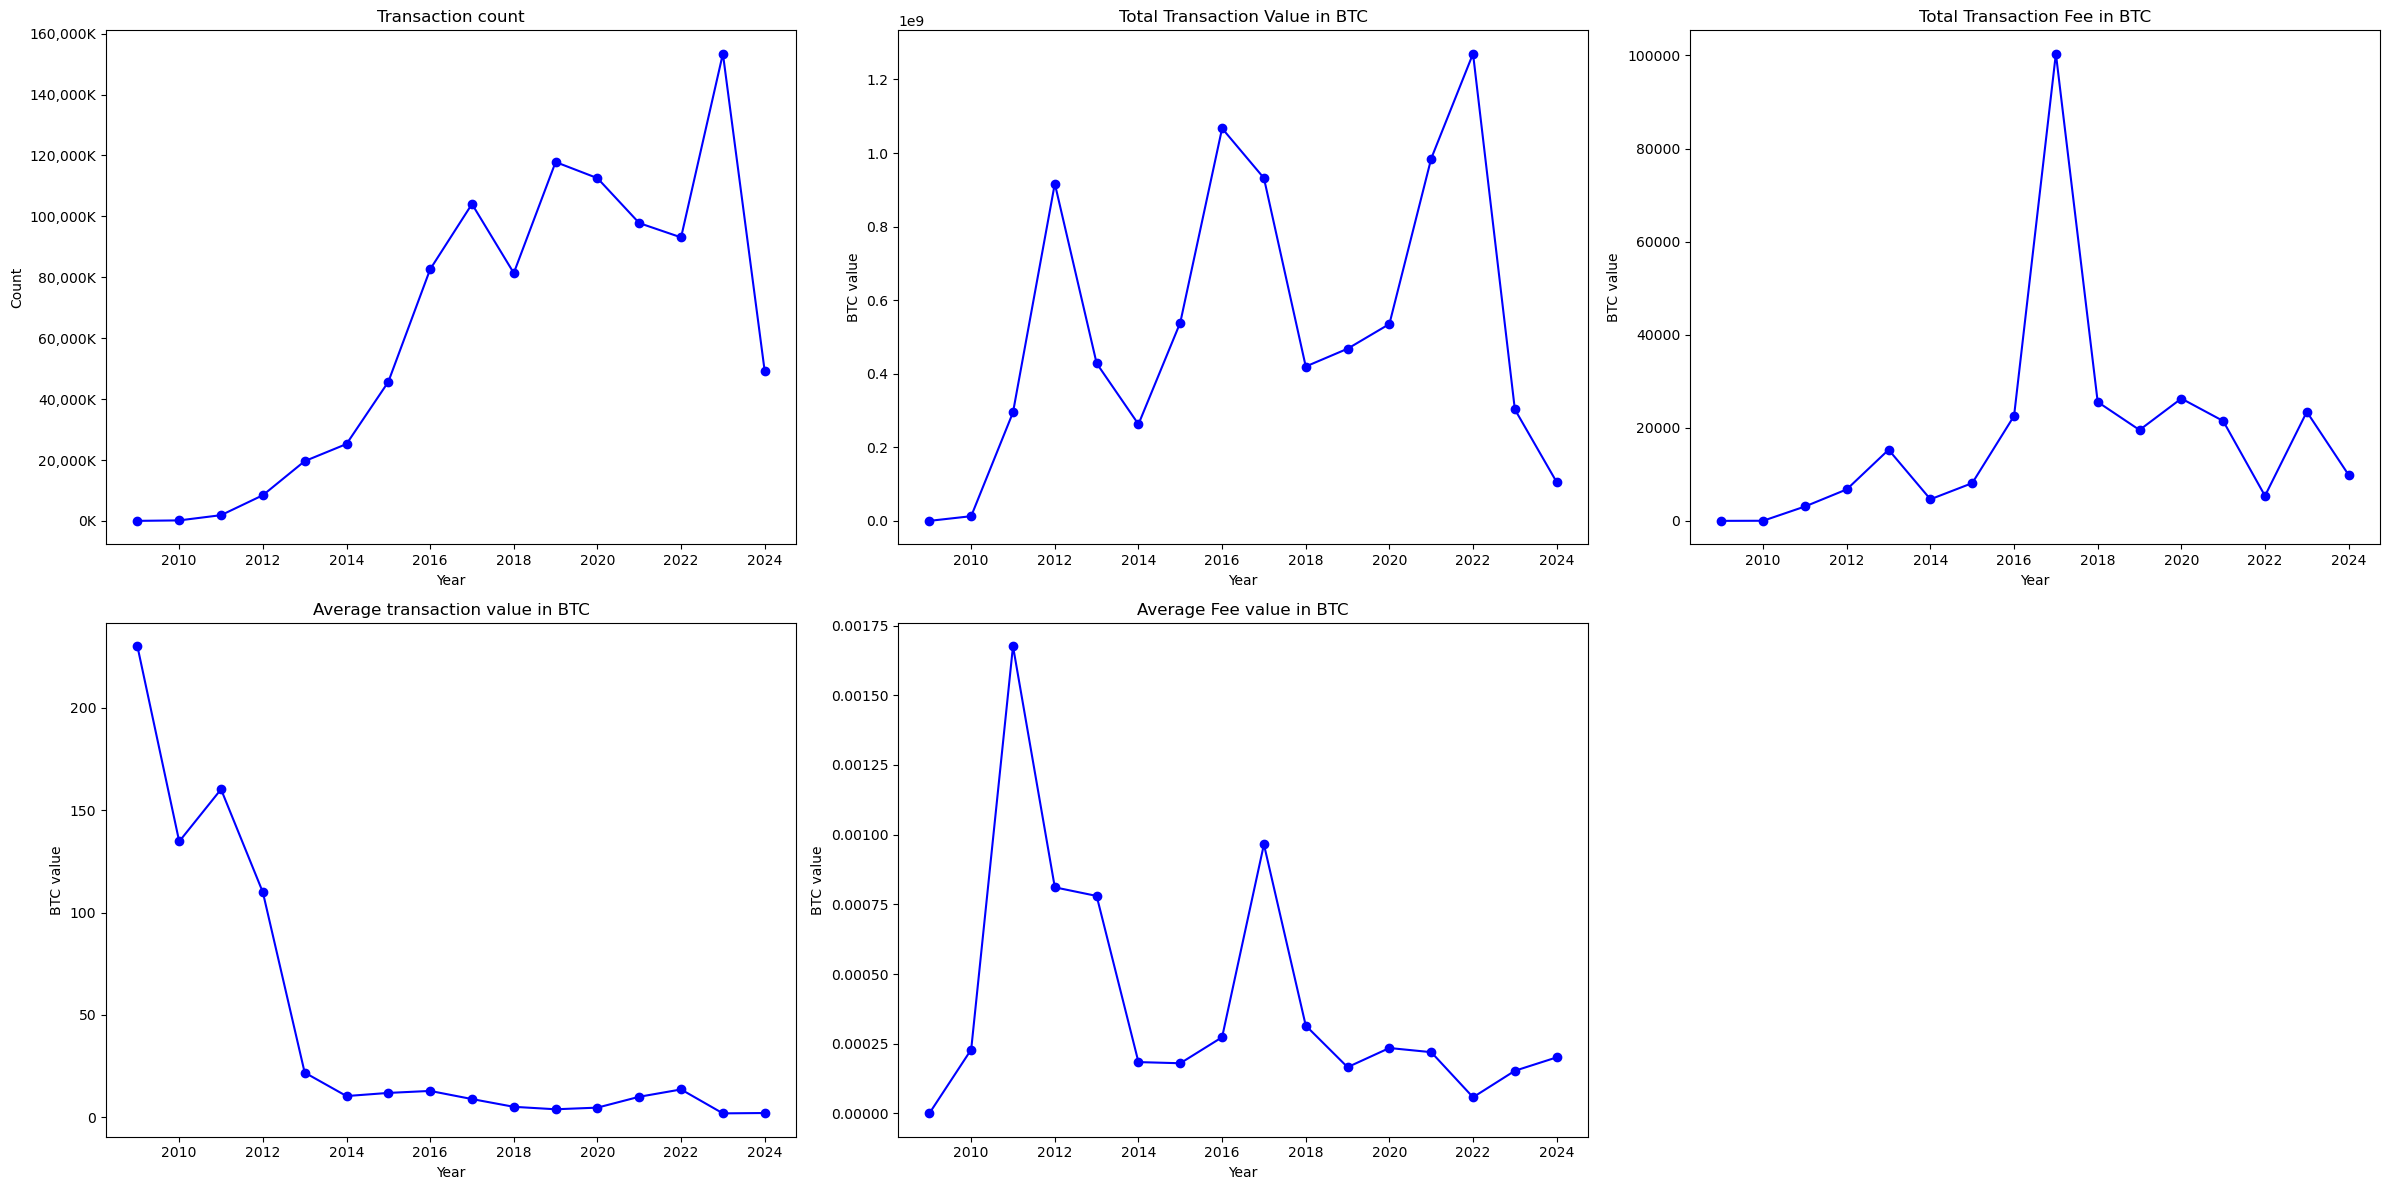

In [24]:
plot_multiple_line_graphs(
    x_list=[btc_tot_trans["year"]] * 5,
    y_list=[btc_tot_trans["total_transactions"], btc_tot_trans["total_value"], btc_tot_trans["total_fee"], btc_tot_trans["avg_value"], btc_tot_trans["avg_fee"]],
    x_labels=["Year"] * 5,
    y_labels=["Count", "BTC value",  "BTC value", "BTC value", "BTC value"],
    titles=["Transaction count", "Total Transaction Value in BTC", "Total Transaction Fee in BTC", "Average transaction value in BTC", "Average Fee value in BTC"],
    use_k=[True, False, False, False, False],
    show_grid=False,
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.